In [ ]:
import random
import string
from math import log, ceil
from time import time, ctime

import numpy as np
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray

import pandas as pd
import matplotlib.pyplot as plt


import subprocess as sp
import time 
import os 
FNULL = open(os.devnull, 'w')
import subprocess as sp
import shlex


In [ ]:
#define parameters for the algorithm
max_calls=275
num_initial_sample=1
percentage_sampled=0.5
# delay_min=20 #(delay_min - delay_window) must be greater than the (number of models + num_initial_smaple)
# delay_max=50
# delay_window=4
# lookahead_max=10
# lookahead_window=4
throttling_times=2.5

#define parameters for the application
n_list=["DGZ","DZG","GDZ","GZD","ZDG","ZGD"]
n_choice=[0,1]
g_choice=[2,3]
d_choice=[4,5]
t_choice=[6,7]
u_choice=[8,9]
#u_choice=[3.0]
f_choice=[10,11]
#f_choice=[2.2]
h_choice=[12,13]
#h_choice=[1]

param_choice = [n_choice, g_choice, d_choice, t_choice, u_choice, f_choice, h_choice]
# n_configs = 81
# print(random.sample(space))

In [ ]:
# Hardware Parameters

def hyperthreading(i):
    if i==0: #off
        j=10
        while j <20:
            comm="sudo bash -c 'echo 0 > /sys/devices/system/cpu/cpu"+str(j)+"/online'"
            os.system(comm)
            j+=1
    if i==1: #on
        j=10
        while j<20:
            comm="sudo bash -c 'echo 1 > /sys/devices/system/cpu/cpu"+str(j)+"/online'"
            os.system(comm)
            j+=1

In [ ]:
def get_params_function():
  total_choice=1
  for cc in range(len(param_choice)):
        total_choice*=len(param_choice[cc])
  Xsamples=[]
  out_count=0
  while out_count < percentage_sampled*total_choice:
      in_list=[]
      in_count=0
      while in_count < len(param_choice):
          in_list.append(random.choice(param_choice[in_count]))
          in_count+=1
      Xsamples.append(in_list)
      out_count+=1
  # test_config = random.sample(XSamples, n_configs)
  return Xsamples # Xsamples returns a exhaustive list of cnfiguration by sampling values randomly from the parm_choice. test_config returns the 81 configs we want to start out experiment with


In [ ]:
# Run the actual application

param_list=[]
exe_list=[]

def try_params_function(list):
    n=n_list[int(list[0])]
    g=int(list[1])
    d=int(list[2])
    t=int(list[3])
    u=list[4]
    f=list[5]
    h=int(list[6])
    hyperthreading(h)
    u_comm="likwid-setFrequencies -umax "+str(u)
    sp.check_output(shlex.split(u_comm), stderr=FNULL)
    f_comm="likwid-setFrequencies -c S0 -f "+str(f)
    sp.check_output(shlex.split(f_comm), stderr=FNULL)
    os.environ["OMP_NUM_THREADS"]=str(t)
    # if len(exe_list)>delay: #throttling only after maturity
    # OMITTING FOR NOW AS MY ALGORITHM DOES NOT DEAL WITH ANY DELAY 
    #     command="timeout "+str(throttling_times*min(exe_list))+" "+"./kripke.exe --groups 64 --quad 192 --layout "+n+" "+"--gset "+str(g)+" "+"--dset "+str(d)
  	# th_list.append(1)
    command="./kripke.exe --groups 64 --quad 192 --layout "+ n +" "+"--gset "+str(g)+" "+"--dset "+str(d)    
    #command="OMP_NUM_THREADS="+str(t)+" "+"./kripke.exe --groups 64 --quad 192 --layout "+n+" "+"--gset "+str(g)+" "+"--dset "+str(d)
    start_time=time.time()
    os.system(command)
    end_time=time.time()
    exe_time=end_time-start_time
    print ("the execution time is", exe_time)
    param_list.append([n,g,d,t,u,f,h])
    exe_list.append(exe_time)
    return -1.0*exe_time

In [ ]:
#Dummy Execution Times 
def try_params_function():
    exe_time = {}
    for i in range(10000):
        key = "loss"
        value = round(random.uniform(0, 1.5), 15)
        exe_time[key] = value
    
    return exe_time


In [ ]:
#Hyperband
class Hyperband:
	
	def __init__( self, get_params_function, try_params_function ):
		self.get_params = get_params_function
		self.try_params = try_params_function
		
		self.max_iter = 81  	# maximum iterations per configuration
		self.eta = 3			# defines configuration downsampling rate (default = 3)

		self.logeta = lambda x: log( x ) / log( self.eta )
		self.s_max = int( self.logeta( self.max_iter ))
		self.B = ( self.s_max + 1 ) * self.max_iter

		self.results = []	# list of dicts
		self.counter = 0
		self.best_loss = np.inf
		self.best_counter = -1

    # Actual function to run
    
	def run( self, skip_last = 0, dry_run = False ):
		
		for s in reversed( range( self.s_max + 1 )):
			
			# initial number of configurations
			n = int( ceil( self.B / self.max_iter / ( s + 1 ) * self.eta ** s ))	
			
			# initial number of iterations per config
			r = self.max_iter * self.eta ** ( -s )		

			# n random configurations
			T = [ self.get_params() for i in range( n )] 
			
			for i in range(( s + 1  ) - int( skip_last )):	# changed from s + 1
				
				# Run each of the n configs for <iterations> 
				# and keep best (n_configs / eta) configurations
				
				n_configs = n * self.eta ** ( -i )
				n_iterations = r * self.eta ** ( i )
				
				print ("\n*** {} configurations x {:.1f} iterations each".format( n_configs, n_iterations ))
				
				val_losses = []
				# early_stops = []
				
				for t in T:
					
					self.counter += 1
					# print ("\n{} | {} | lowest loss so far: {:.4f} (run {})\n".format( 
					# 	self.counter, ctime(), self.best_loss, self.best_counter ))
					
					start_time = time()
					
					if dry_run:
						result = { 'loss': random(), 'log_loss': random(), 'auc': random()}
					else:
						#Dry run "List" parameter of the try_params_function is omitted. INlcude for real try_params_function 
						result = try_params_function()		# This line returns the validation losses(execution Time). Here we will call our try_params_function  to run the application with our sampled parameters
						
					assert( type( result ) == dict )
					# assert( 'loss' in result )
					
					seconds = int( round( time() - start_time ))
					# print ("\n{} seconds.".format( seconds ))
					
					loss = result['loss']	
					val_losses.append( loss )
					
					# early_stop = result.get( 'early_stop', False )
					# early_stops.append( early_stop )
					
					# keeping track of the best result so far (for display only)
					# could do it be checking results each time, but hey
					if loss < self.best_loss:
						self.best_loss = loss
						self.best_counter = self.counter
					
					result['counter'] = self.counter
					result['seconds'] = seconds
					result['params'] = t
					result['iterations'] = n_iterations  #{'loss': 6, 'counter': 1, 'seconds': 3.337860107421875e-06, 'params': [1, 2, 3], 'iterations': 10}
					
					self.results.append( result )
				
				
				# select a number of best configurations for the next loop
				# filter out early stops, if any
				indices = np.argsort( val_losses )
				T = [ T[i] for i in indices]
				T = T[ 0:int( n_configs / self.eta )]
			print("____________________________________________________________________________")

		
		return self.results

In [ ]:
hb = Hyperband( get_params_function, try_params_function )
results = hb.run( skip_last = 0 )


*** 81 configurations x 1.0 iterations each

*** 27.0 configurations x 3.0 iterations each

*** 9.0 configurations x 9.0 iterations each

*** 3.0 configurations x 27.0 iterations each

*** 1.0 configurations x 81.0 iterations each
______________________________________________

*** 34 configurations x 3.0 iterations each

*** 11.333333333333332 configurations x 9.0 iterations each

*** 3.7777777777777777 configurations x 27.0 iterations each

*** 1.259259259259259 configurations x 81.0 iterations each
______________________________________________

*** 15 configurations x 9.0 iterations each

*** 5.0 configurations x 27.0 iterations each

*** 1.6666666666666665 configurations x 81.0 iterations each
______________________________________________

*** 8 configurations x 27.0 iterations each

*** 2.6666666666666665 configurations x 81.0 iterations each
______________________________________________

*** 5 configurations x 81.0 iterations each
_____________________________________________

In [ ]:
print(results)
print ("\n{} is the size of the list 'self.results'.".format( len(results )))
print ("\n{} is the size of the list 'self.results/params'\n".format( (len(results[4]['params']))))
for d in results[:10]:
  print(d)

[{'loss': 1.387700124534413, 'counter': 1, 'seconds': 0, 'params': [[0, 3, 4, 7, 8, 10, 13], [0, 2, 4, 6, 9, 11, 13], [0, 2, 5, 7, 9, 10, 12], [1, 2, 4, 6, 9, 11, 12], [0, 3, 5, 6, 9, 11, 12], [0, 2, 5, 6, 8, 10, 12], [0, 2, 5, 6, 9, 11, 12], [1, 2, 4, 7, 8, 11, 12], [0, 2, 5, 6, 9, 11, 12], [1, 3, 4, 6, 8, 11, 13], [0, 2, 4, 6, 9, 11, 12], [1, 3, 4, 6, 8, 11, 13], [1, 3, 5, 7, 9, 11, 12], [1, 3, 5, 6, 8, 11, 12], [0, 3, 5, 6, 8, 11, 13], [0, 3, 4, 7, 9, 10, 13], [1, 2, 4, 7, 9, 11, 13], [1, 3, 4, 6, 9, 11, 12], [0, 3, 5, 6, 8, 10, 12], [0, 2, 4, 7, 9, 10, 13], [0, 2, 4, 7, 9, 10, 13], [1, 2, 4, 7, 8, 10, 13], [0, 3, 4, 6, 9, 10, 12], [0, 3, 4, 7, 8, 10, 13], [1, 2, 4, 6, 9, 11, 12], [1, 2, 4, 6, 8, 11, 12], [1, 3, 5, 7, 8, 11, 13], [0, 2, 4, 7, 8, 11, 12], [1, 2, 5, 6, 8, 11, 12], [0, 2, 4, 7, 8, 11, 13], [0, 2, 5, 7, 8, 10, 13], [1, 2, 5, 6, 8, 10, 13], [0, 2, 5, 6, 8, 11, 12], [0, 2, 4, 7, 8, 10, 12], [1, 2, 5, 7, 9, 10, 13], [0, 3, 4, 6, 8, 11, 13], [0, 3, 5, 7, 9, 10, 12], [1, 2, 

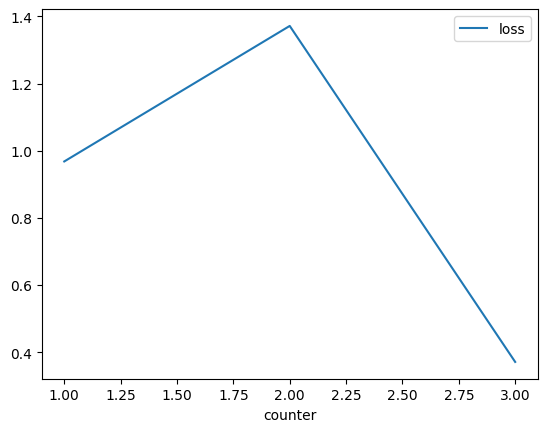

In [ ]:
# Creating Pandas DF

df = pd.DataFrame([(d['counter'], d['loss']) for d in results], columns=['counter', 'loss'])
df = df[0:3]

# print(df)

# plot the dataframe
df.plot(kind='line', x='counter', y='loss')

# display the chart
plt.show()

In [ ]:
#Generate Log files

with open('param_list.txt', 'w') as f:
   	 for item in param_list:
        	print >> f, item
with open('exe_list.txt', 'w') as f:
  for item in exe_list:
      print >> f, item